<a href="https://colab.research.google.com/github/Samuela31/Deep-Learning-Laboratory/blob/main/DL_Lab_7_Time_Series_Forecasting_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
df=pd.read_csv("CAC40_stocks_2021_2023.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,2020-04-08,28.559999,28.559999,26.639999,28.270000,28.270000,1051666.0,AC.PA
1,2020-04-09,28.629999,29.570000,28.049999,28.639999,28.639999,990955.0,AC.PA
2,2020-04-14,28.010000,28.340000,27.150000,27.590000,27.590000,907178.0,AC.PA
3,2020-04-15,27.170000,27.299999,25.459999,25.660000,25.660000,1378290.0,AC.PA
4,2020-04-16,25.879999,26.700001,24.080000,24.570000,24.570000,1474307.0,AC.PA
...,...,...,...,...,...,...,...,...
28559,2023-03-31,19.125000,19.195000,18.860001,18.910000,18.910000,930746.0,FR.PA
28560,2023-04-03,18.940001,19.325001,18.820000,19.070000,19.070000,819094.0,FR.PA
28561,2023-04-04,19.170000,19.309999,18.775000,18.775000,18.775000,931876.0,FR.PA
28562,2023-04-05,18.785000,18.799999,17.815001,18.125000,18.125000,1518496.0,FR.PA


In [ ]:
def load_data(start, end):
    """
    Load data for the specified stock and date range.
    """
    dataframe = df.copy()
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])  # Convert 'Date' column to datetime
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    return dataframe

In [ ]:
start_date = dt.datetime(2020,4,8)
end_date = dt.datetime(2023,1,1)

START_DATE_TEST = end_date

data = load_data(start_date, end_date)

In [ ]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [ ]:
scaled_data

array([[0.01344512],
       [0.01281612],
       [0.01165995],
       ...,
       [0.00633737],
       [0.00648713],
       [0.00629244]])

In [ ]:
# Set the number of days used for prediction
prediction_days = 60

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_days:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
print(x_train)

[[[0.01344512]
  [0.01281612]
  [0.01165995]
  ...
  [0.01114476]
  [0.01110882]
  [0.01144429]]

 [[0.01281612]
  [0.01165995]
  [0.01100698]
  ...
  [0.01110882]
  [0.01144429]
  [0.01120467]]

 [[0.01165995]
  [0.01100698]
  [0.01236683]
  ...
  [0.01144429]
  [0.01120467]
  [0.01101297]]

 ...

 [[0.00629544]
  [0.00563948]
  [0.00595098]
  ...
  [0.00617263]
  [0.00630742]
  [0.0063194 ]]

 [[0.00563948]
  [0.00595098]
  [0.00590605]
  ...
  [0.00630742]
  [0.0063194 ]
  [0.00633737]]

 [[0.00595098]
  [0.00590605]
  [0.00580122]
  ...
  [0.0063194 ]
  [0.00633737]
  [0.00648713]]]


In [ ]:
print(y_train)

[0.01120467 0.01101297 0.01055769 ... 0.00633737 0.00648713 0.00629244]


In [ ]:
# Initialize a sequential model
model = Sequential()

# Add the first LSTM layer with 50 units, input shape, and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# Add dropout to prevent overfitting
model.add(Dropout(0.2))

# Add a second LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True))
# Add dropout to prevent overfitting
model.add(Dropout(0.2))

# Add a third LSTM layer with 50 units
model.add(LSTM(units=50))
# Add dropout to prevent overfitting
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(units=1))

In [ ]:
model.summary()
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
model.fit(
    x_train,
    y_train,
    epochs=25,
    batch_size = 32,
)

Epoch 1/25
810/810 [==============================] - 76s 86ms/step - loss: 8.1536e-04
Epoch 2/25
810/810 [==============================] - 71s 88ms/step - loss: 4.9371e-04
Epoch 3/25
810/810 [==============================] - 72s 89ms/step - loss: 3.4587e-04
Epoch 4/25
810/810 [==============================] - 71s 87ms/step - loss: 3.7029e-04
Epoch 5/25
810/810 [==============================] - 72s 88ms/step - loss: 3.3350e-04
Epoch 6/25
810/810 [==============================] - 71s 88ms/step - loss: 3.1796e-04
Epoch 7/25
810/810 [==============================] - 71s 88ms/step - loss: 3.2937e-04
Epoch 8/25
810/810 [==============================] - 70s 86ms/step - loss: 2.9032e-04
Epoch 9/25
810/810 [==============================] - 73s 90ms/step - loss: 2.8509e-04
Epoch 10/25
810/810 [==============================] - 71s 87ms/step - loss: 2.9937e-04
Epoch 11/25
810/810 [==============================] - 72s 89ms/step - loss: 2.4418e-04
Epoch 12/25
810/810 [====================

In [ ]:
# Load test data for the specified company and date range
test_data = load_data(
    start=START_DATE_TEST,
    end=dt.datetime.now()
)

# Extract the actual closing prices from the test data
actual_prices = test_data['Close'].values

# Concatenate the training and test data along the 'Close' column
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler.transform(model_inputs)

In [ ]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

80/80 [==============================] - 3s 27ms/step


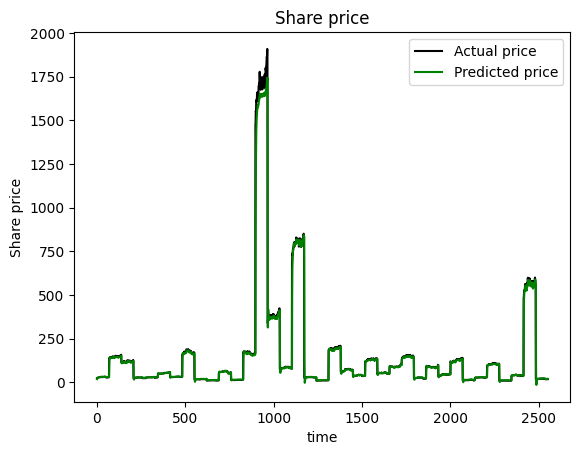

In [ ]:
# Plot the actual prices using a black line
plt.plot(actual_prices, color='black', label="Actual price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label="Predicted price")

# Set the title of the plot using the company name
plt.title("Share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel("Share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

In [ ]:
# Extract the last 'prediction_days' values from the model inputs
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]

# Convert the real_data list to a numpy array
real_data = np.array(real_data)

# Reshape real_data to a 3D array with the appropriate dimensions for the LSTM model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Generate a prediction using the LSTM model with the real_data input
prediction = model.predict(real_data)

# Invert the scaling applied to the prediction to obtain the actual value
prediction = scaler.inverse_transform(prediction)

# Print the prediction result to the console
print(f"MSE: {prediction[0][0]}")

1/1 [==============================] - 0s 46ms/step
MSE: 19.772687911987305
